In [54]:
import numpy as np
import pylab
import pandas as pd
import json
import os
import requests

In [55]:
def DownloadFiller(file, url):
    if not os.path.isfile(file):
        myfile = requests.get(url)
        open(file, 'wb').write(myfile.content)
    

In [56]:
DownloadFiller("./TitleAbstractMatches_therapies.csv",  "https://docs.google.com/uc?export=download&id=1zcEfIGYgbqQrsS_DVm-e8IsJRM3dhc5w")
DownloadFiller("./TitleAbstractMatches_drugs.csv",      "https://docs.google.com/uc?export=download&id=1dQsWY5gyKtaAYlJprkeWq-nF697uFymK")
DownloadFiller("./TitleAbstractMatches_exps.csv",       "https://docs.google.com/uc?export=download&id=1zcEfIGYgbqQrsS_DVm-e8IsJRM3dhc5w")
DownloadFiller("./TitleAbstractMatches_virusnames.csv", "https://docs.google.com/uc?export=download&id=1e-52CS4zX8qXk9euUE0fzVQAWITSmWoS")

In [57]:
# Load CSV files
dat_therapies=pd.read_csv("./TitleAbstractMatches_therapies.csv")
dat_drugs= pd.read_csv("./TitleAbstractMatches_drugs.csv")
dat_viruses= pd.read_csv("./TitleAbstractMatches_virusnames.csv")
dat_exps= pd.read_csv("./TitleAbstractMatches_exptypes.csv")

In [58]:
# Drop pointless column
dat_drugs=dat_drugs.drop('Unnamed: 0',axis=1).set_index('block')
dat_therapies=dat_therapies.drop('Unnamed: 0',axis=1).set_index('block')
dat_viruses=dat_viruses.drop('Unnamed: 0',axis=1).set_index('block')
dat_exps=dat_exps.drop('Unnamed: 0',axis=1).set_index('block')

In [59]:
# With the new extended drug lexicon, we'll need to restrict to a 
# subset for good visuals
drugsubset=["naproxen","clarithromycin","chloroquine","kaletra","Favipiravir","Avigan",'hydroxychloroquine','baricitinib']

In [60]:
# We'll use this function later to see if two words are in the same sentence
#  within the block

def SameSentenceCheck(block,pos1,pos2):
    if(pos1<pos2):
        Interstring=block[int(pos1):int(pos2)]
    else:
        Interstring=block[int(pos2):int(pos1)]
    SentenceEnders=[".",";","?","!"]
    for s in SentenceEnders:
        if s in Interstring:
            return 0
    return 1

In [61]:
def Make2DPlot(dat_joined, factor1, factor2, single_sentence_plots=False):
    if(single_sentence_plots):
        grouped = dat_joined[dat_joined.same_sentence==True].groupby(['word_'+factor1,'word_'+factor2])
    else:
        grouped = dat_joined.groupby(['word_'+factor1,'word_'+factor2])

    Values    = grouped.count().values[:,0]

    Index=grouped.count().index
    Index1=[]
    Index2=[]
    for i in Index:
        Index1.append(i[0])
        Index2.append(i[1])

    Uniq1=np.unique(Index1)
    Uniq2=np.unique(Index2)

    for i in range(0,len(Index1)):
        Index1[i]=np.where(Index1[i]==Uniq1)[0][0]
        Index2[i]=np.where(Index2[i]==Uniq2)[0][0]

    pylab.figure(figsize=(5,5),dpi=200)
    hist=pylab.hist2d(Index1,Index2, (range(0,len(Uniq1)+1),range(0,len(Uniq2)+1)), weights=Values,cmap='Blues')
    pylab.xticks(np.arange(0,len(Uniq1))+0.5, Uniq1,rotation=90)
    pylab.yticks(np.arange(0,len(Uniq2))+0.5, Uniq2)
    pylab.clim(0,np.max(hist[0])*1.5)
    for i in range(0,len(Uniq1)):
        for j in range(0,len(Uniq2)):
            pylab.text(i+0.5,j+0.5,int(hist[0][i][j]),ha='center',va='center')

    pylab.colorbar()
    if(single_sentence_plots):
        pylab.title(factor1+" and " +factor2+" in One Sentence")
        pylab.tight_layout()
        pylab.savefig("Overlap"+factor1+"_Vs_"+factor2+"_2D_sentence.png",bbox_inches='tight',dpi=200)
    else:
        pylab.title(factor1+" and " +factor2+" in One Block")
        pylab.tight_layout()
        pylab.savefig("Overlap"+factor1+"_Vs_"+factor2+"_2D_block.png",bbox_inches='tight',dpi=200)

    


#  Virus / Therapy word coincidences

In [62]:
# Prune and join, and extract overlap counts
dat_joined_vt=dat_therapies.join(dat_viruses, rsuffix='_virus',lsuffix="_therapy")
dat_joined_vt=dat_joined_vt[dat_joined_vt.notna().word_therapy & dat_joined_vt.notna().word_virus]


#Make single sentence index
dat_joined_vt=dat_joined_vt.drop(["sha_therapy","blockid_therapy","sec_therapy"],axis=1).reset_index().rename(columns={"sha_virus":"sha","blockid_virus":"blockid","sec_virus":"sec"})
SingleSentence=[]
for i in dat_joined_vt.index:
    SingleSentence.append(SameSentenceCheck(dat_joined_vt.block[i],dat_joined_vt.pos_virus[i],dat_joined_vt.pos_therapy[i]))
dat_joined_vt.insert(len(dat_joined_vt.columns),'same_sentence',SingleSentence)
dat_joined_vt.to_csv("Overlaps_Virus_Therapy.csv")


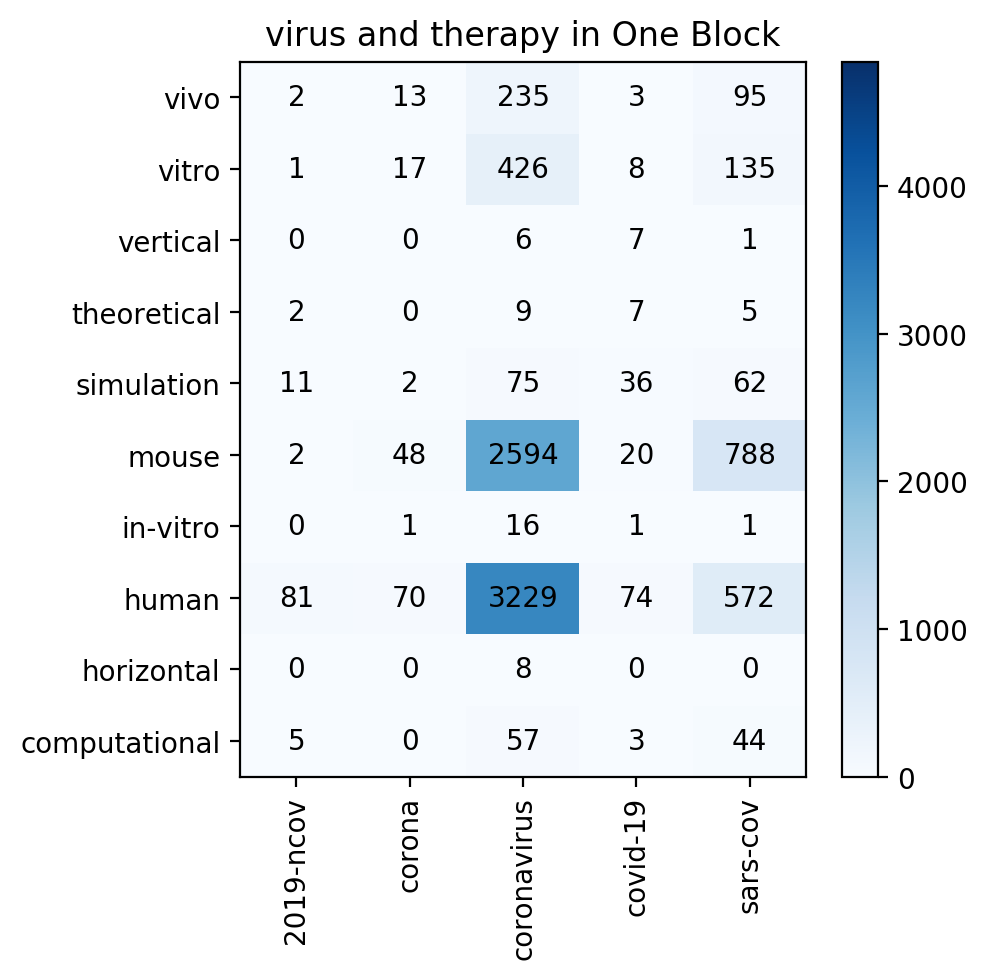

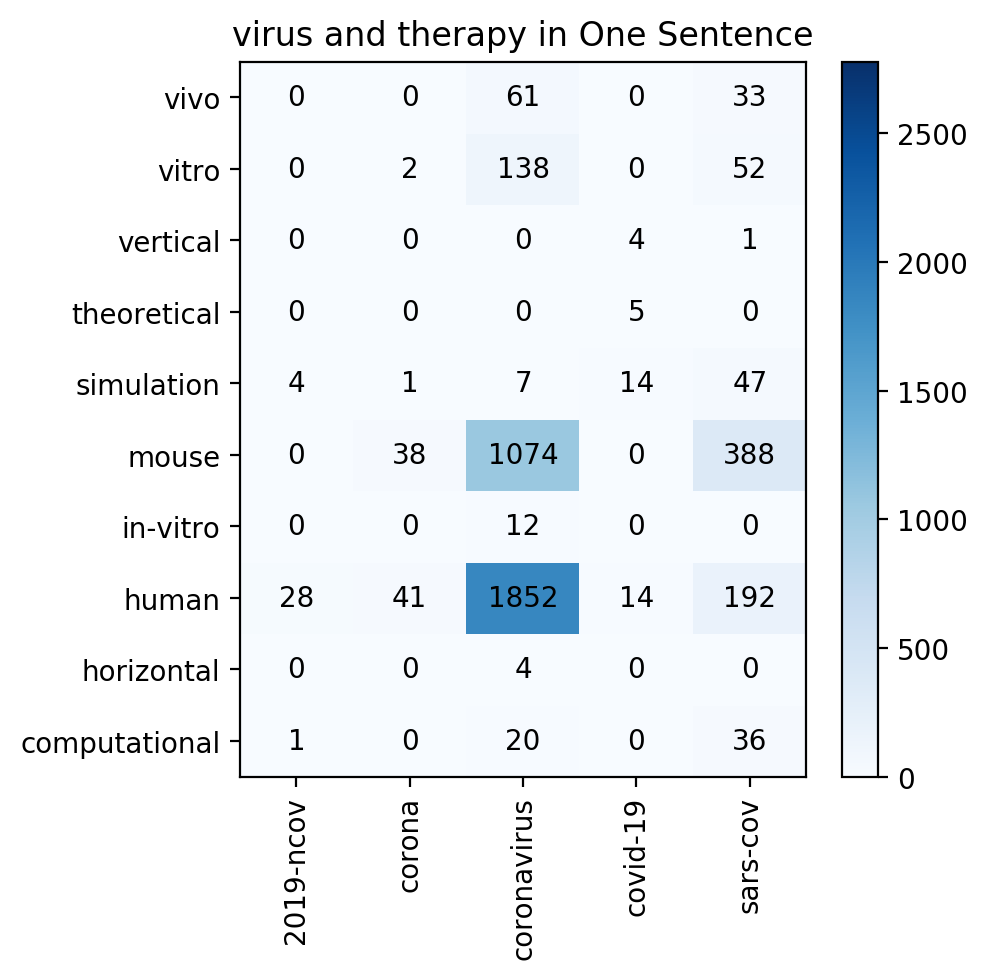

In [63]:
Make2DPlot(dat_joined_vt,"virus","therapy")
Make2DPlot(dat_joined_vt,"virus","therapy",single_sentence_plots=True)

# Virus / Drug coincidences


In [64]:
# Prune and join, and extract overlap counts
dat_joined_vd=dat_drugs.join(dat_viruses, rsuffix='_virus',lsuffix="_drug")
dat_joined_vd=dat_joined_vd[dat_joined_vd.notna().word_drug & dat_joined_vd.notna().word_virus]

dat_joined_vd=dat_joined_vd.drop(["sha_drug","blockid_drug","sec_drug"],axis=1).reset_index().rename(columns={"sha_virus":"sha","blockid_virus":"blockid","sec_virus":"sec"})
SingleSentence=[]
for i in dat_joined_vd.index:
    SingleSentence.append(SameSentenceCheck(dat_joined_vd.block[i],dat_joined_vd.pos_drug[i],dat_joined_vd.pos_drug[i]))
dat_joined_vd.insert(len(dat_joined_vd.columns),'same_sentence',SingleSentence)
dat_joined_vd.to_csv("Overlaps_Virus_Drug.csv")

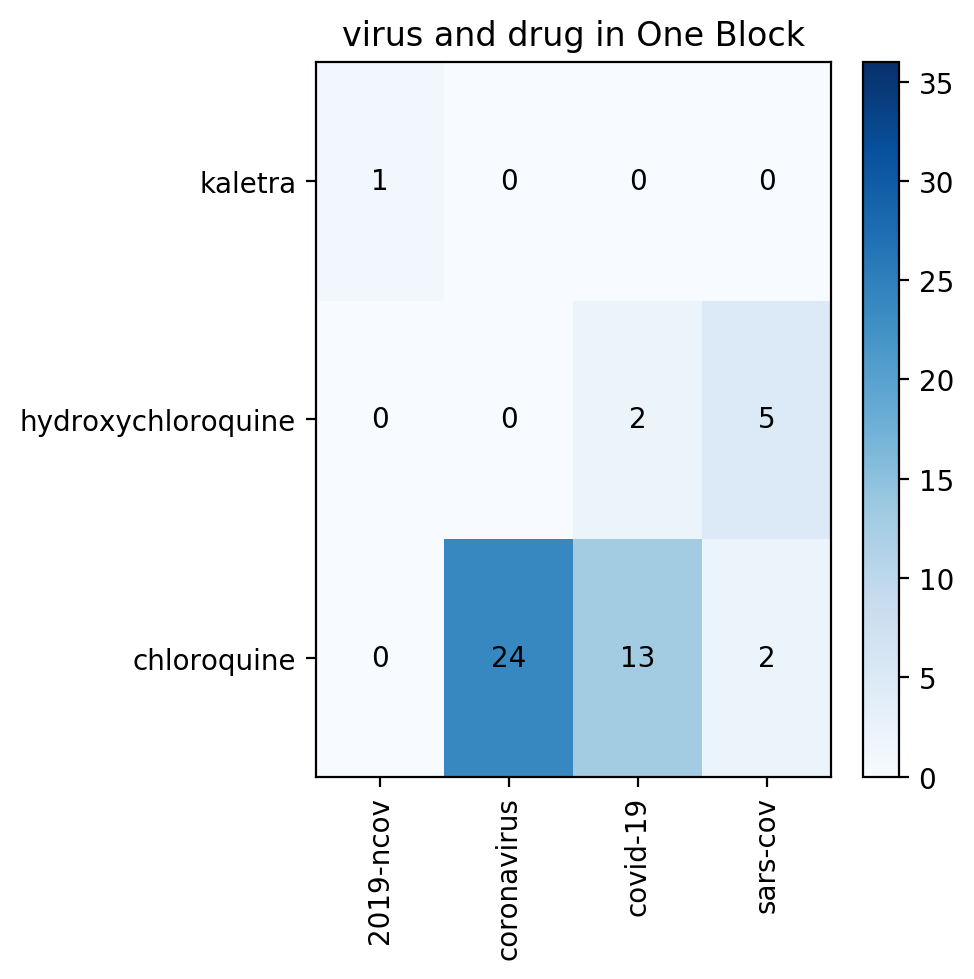

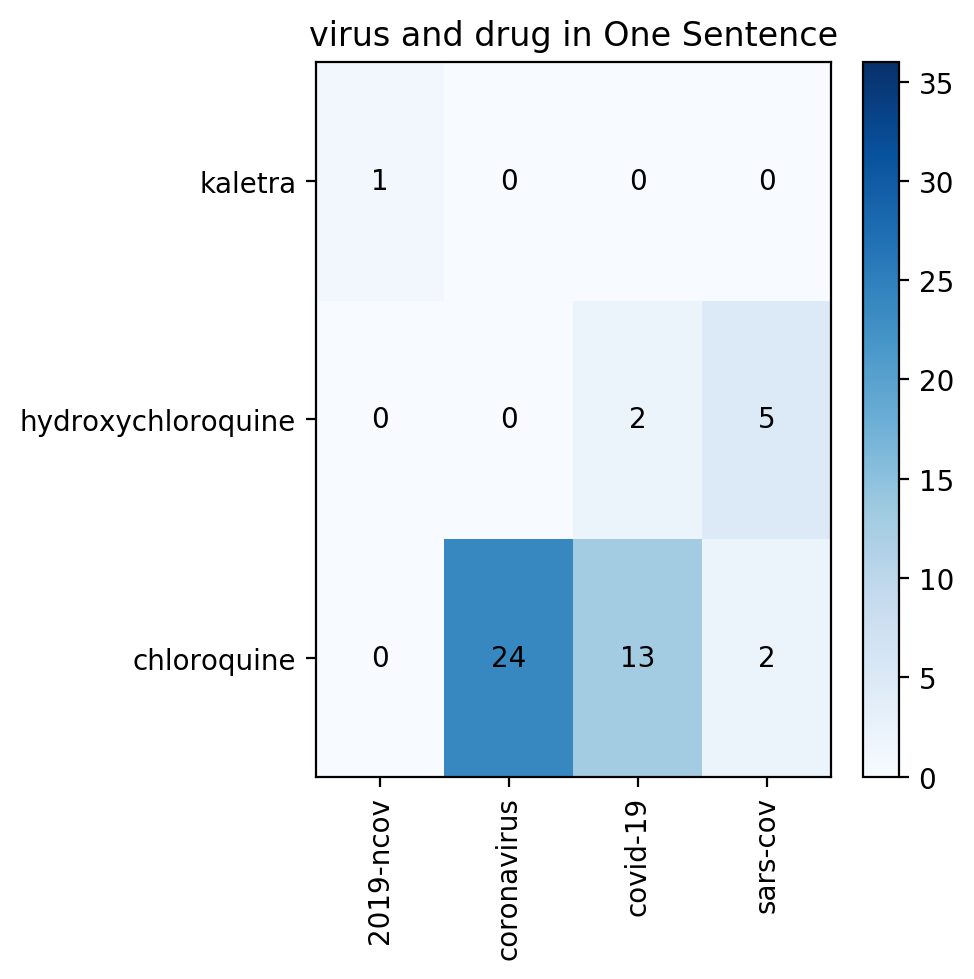

In [65]:
Make2DPlot(dat_joined_vd[dat_joined_vd.word_drug.isin(drugsubset)],"virus","drug")
Make2DPlot(dat_joined_vd[dat_joined_vd.word_drug.isin(drugsubset)],"virus","drug",single_sentence_plots=True)

# Drug / Therapy Coincidences

In [66]:
# Prune and join, and extract overlap counts
dat_joined_dt=dat_drugs.join(dat_therapies, rsuffix='_therapy',lsuffix="_drug")
dat_joined_dt=dat_joined_dt[dat_joined_dt.notna().word_drug & dat_joined_dt.notna().word_therapy]

dat_joined_dt=dat_joined_dt.drop(["sha_drug","blockid_drug","sec_drug"],axis=1).reset_index().rename(columns={"sha_therapy":"sha","blockid_therapy":"blockid","sec_therapy":"sec"})
SingleSentence=[]
for i in dat_joined_dt.index:
    SingleSentence.append(SameSentenceCheck(dat_joined_dt.block[i],dat_joined_dt.pos_drug[i],dat_joined_dt.pos_therapy[i]))
dat_joined_dt.insert(len(dat_joined_dt.columns),'same_sentence',SingleSentence)
dat_joined_dt.to_csv("Overlaps_Drug_Therapy.csv")


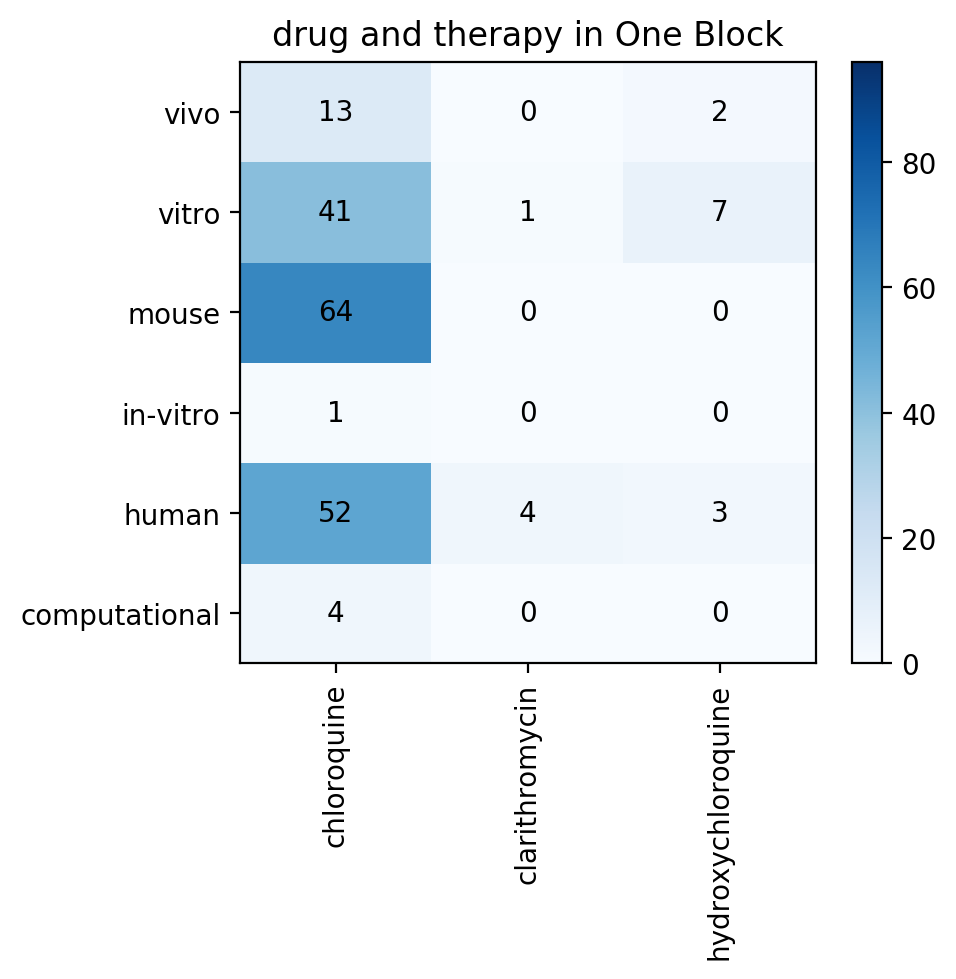

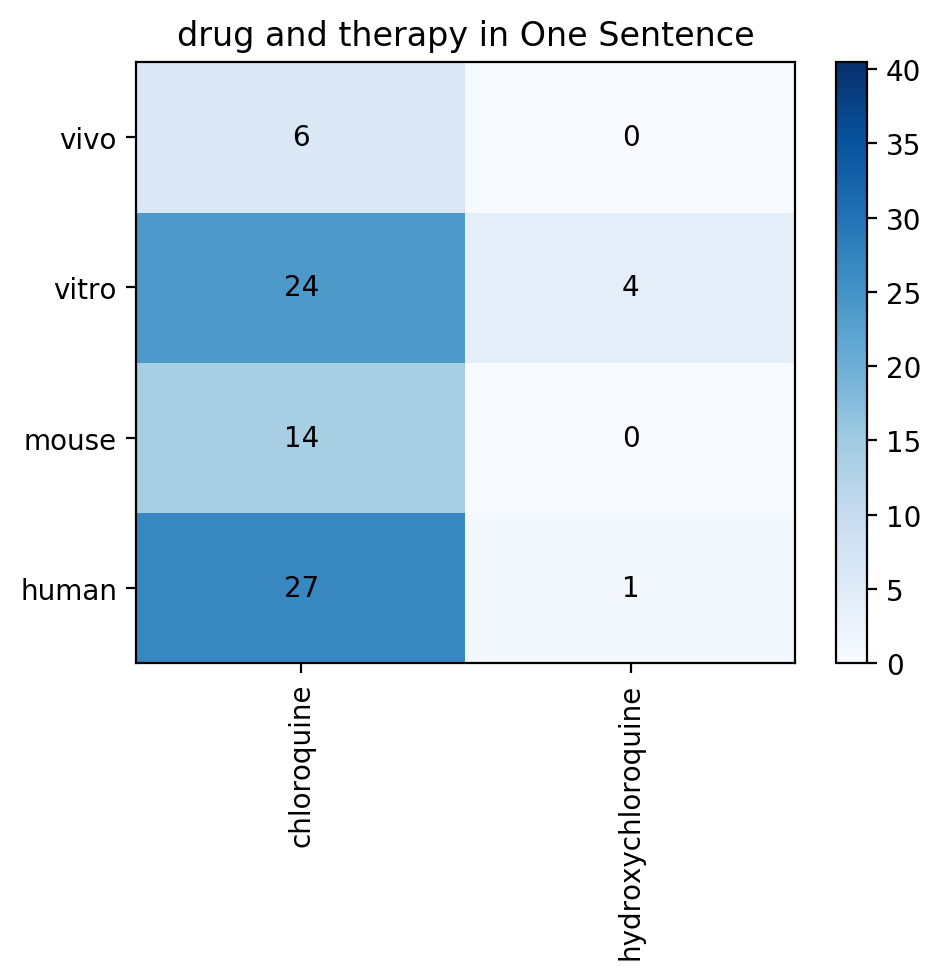

In [67]:
Make2DPlot(dat_joined_dt[dat_joined_dt.word_drug.isin(drugsubset)],"drug","therapy")
Make2DPlot(dat_joined_dt[dat_joined_dt.word_drug.isin(drugsubset)],"drug","therapy",single_sentence_plots=True)

# Experiment Type and Drug

In [68]:
# Prune and join, and extract overlap counts
dat_joined_de=dat_drugs.join(dat_exps, rsuffix='_exp',lsuffix="_drug")
dat_joined_de=dat_joined_de[dat_joined_de.notna().word_drug & dat_joined_de.notna().word_exp]

dat_joined_de=dat_joined_de.drop(["sha_drug","blockid_drug","sec_drug"],axis=1).reset_index().rename(columns={"sha_exp":"sha","blockid_exp":"blockid","sec_exp":"sec"})
SingleSentence=[]
for i in dat_joined_de.index:
    SingleSentence.append(SameSentenceCheck(dat_joined_de.block[i],dat_joined_de.pos_drug[i],dat_joined_de.pos_exp[i]))
dat_joined_de.insert(len(dat_joined_de.columns),'same_sentence',SingleSentence)
dat_joined_de.to_csv("Overlaps_Drug_Experiment.csv")

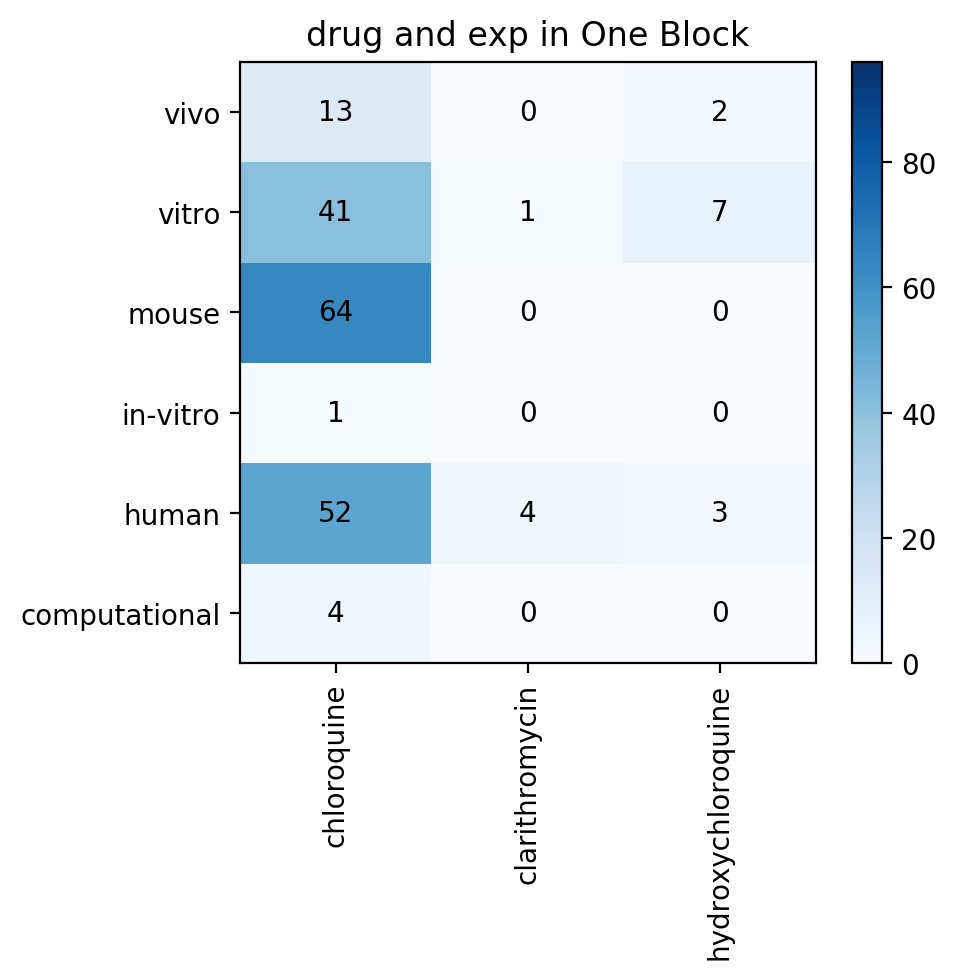

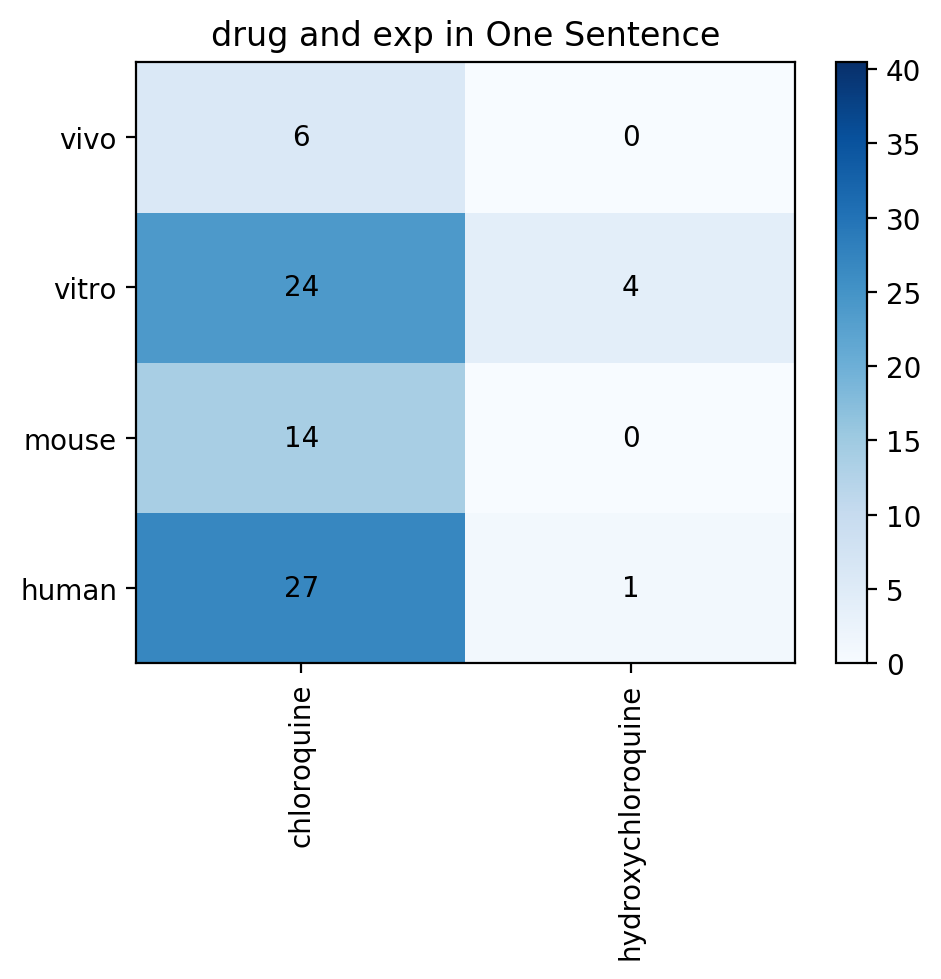

In [69]:
Make2DPlot(dat_joined_de[dat_joined_de.word_drug.isin(drugsubset)],"drug","exp")
Make2DPlot(dat_joined_de[dat_joined_de.word_drug.isin(drugsubset)],"drug","exp",single_sentence_plots=True)

# Tripartite Coincidences

In [70]:
dat_joined_vtd=dat_therapies.join(dat_viruses, rsuffix='_virus',lsuffix="_therapy").join(dat_drugs)
dat_joined_vtd=dat_joined_vtd[dat_joined_vtd.notna().word_therapy & dat_joined_vtd.notna().word_virus & dat_joined_vtd.notna().word]
grouped_vtd=dat_joined_vtd.groupby(['word_therapy','word_virus','word'])
grouped_vtd.count().sha_therapy


word_therapy   word_virus   word       
computational  2019-ncov    lopinavir       1
               coronavirus  amiodarone      2
                            azelastine      2
                            chloroquine     2
                            cholesterol     1
                                           ..
vivo           sars-cov     papain         10
                            perform         2
                            sugar           1
                            trypsin         2
                            yeast           1
Name: sha_therapy, Length: 477, dtype: int64

In [71]:
dat_joined_vtd=dat_joined_vtd.reset_index().drop(['sha_therapy','blockid_therapy','sec_therapy','sha_virus','blockid_virus','sec_virus'],axis=1).rename(columns={'word':'word_drug','pos':'pos_drug'}).set_index('sha')


In [72]:
dat_joined_vtd=dat_joined_vtd[["block","sec","blockid","word_therapy","pos_therapy","word_virus", "pos_virus","word_drug","pos_drug"]]


In [73]:
dat_joined_vtd.to_csv("Overlaps_Drug_Therapy_Virus.csv")